In [1]:
import os
import time
import torch
import albumentations as A
import pandas as pd
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from albumentations.pytorch import ToTensorV2
from torch.optim import AdamW
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import ImageFolder
from torch.optim.lr_scheduler import ReduceLROnPlateau
from PIL import Image
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score
import random

import wandb

import timm
from dotenv import load_dotenv
from datetime import datetime  # datetime 모듈에서 datetime 클래스를 임포트합니다.
from zoneinfo import ZoneInfo  # Python 3.9+에서 ZoneInfo를 임포트합니다.

In [2]:
import timm

# 사용할 수 있는 모델 목록 확인
model_names = timm.list_models()
print(model_names)


['bat_resnext26ts', 'beit_base_patch16_224', 'beit_base_patch16_384', 'beit_large_patch16_224', 'beit_large_patch16_384', 'beit_large_patch16_512', 'beitv2_base_patch16_224', 'beitv2_large_patch16_224', 'botnet26t_256', 'botnet50ts_256', 'caformer_b36', 'caformer_m36', 'caformer_s18', 'caformer_s36', 'cait_m36_384', 'cait_m48_448', 'cait_s24_224', 'cait_s24_384', 'cait_s36_384', 'cait_xs24_384', 'cait_xxs24_224', 'cait_xxs24_384', 'cait_xxs36_224', 'cait_xxs36_384', 'coat_lite_medium', 'coat_lite_medium_384', 'coat_lite_mini', 'coat_lite_small', 'coat_lite_tiny', 'coat_mini', 'coat_small', 'coat_tiny', 'coatnet_0_224', 'coatnet_0_rw_224', 'coatnet_1_224', 'coatnet_1_rw_224', 'coatnet_2_224', 'coatnet_2_rw_224', 'coatnet_3_224', 'coatnet_3_rw_224', 'coatnet_4_224', 'coatnet_5_224', 'coatnet_bn_0_rw_224', 'coatnet_nano_cc_224', 'coatnet_nano_rw_224', 'coatnet_pico_rw_224', 'coatnet_rmlp_0_rw_224', 'coatnet_rmlp_1_rw2_224', 'coatnet_rmlp_1_rw_224', 'coatnet_rmlp_2_rw_224', 'coatnet_rmlp_2


1. **Lightweight MobileNets and GhostNets**:
   - `mobilenetv2_035`, `mobilenetv2_050`, `mobilenetv2_075`, `mobilenetv2_100`, `mobilenetv3_small_050`, `mobilenetv3_small_075`, `mobilenetv3_small_100`, `ghostnet_050`, `ghostnet_100`, `ghostnetv2_100`, `ghostnetv2_130`, `ghostnetv2_160`

2. **EfficientNets (Lite models)**:
   - `efficientnet_lite0`, `efficientnet_lite1`, `efficientnet_lite2`, `efficientnet_lite3`, `efficientnet_lite4`

3. **Tiny and Small ViT Models**:
   - `vit_tiny_patch16_224`, `vit_tiny_patch16_384`, `vit_small_patch16_224`, `vit_small_patch16_384`

4. **Small EfficientNets and MobileViTs**:
   - `efficientnet_b0`, `efficientnet_b1`, `efficientnet_b2`, `efficientnet_b3`, `efficientnetv2_rw_s`, `mobilevit_xs`, `mobilevit_s`

5. **CoaT Models (Lite variants)**:
   - `coat_lite_tiny`, `coat_lite_mini`, `coat_lite_small`, `coat_lite_medium`

6. **Cait and ResNet Variants**:
   - `cait_xxs24_224`, `cait_xxs24_384`, `resnet18`, `resnet34`

7. **MixNet and EfficientNets (Base models)**:
   - `mixnet_s`, `mixnet_m`, `mixnet_l`, `efficientnet_b4`, `efficientnet_b5`

8. **DLA Models**:
   - `dla34`, `dla46_c`, `dla46x_c`, `dla60`, `dla60_res2net`, `dla60_res2next`, `dla60x`, `dla60x_c`

9. **RegNet and RexNet Models**:
   - `regnetx_002`, `regnetx_004`, `regnetx_006`, `rexnet_100`, `rexnet_130`, `rexnetr_100`, `rexnetr_130`

10. **ViT Base and Larger EfficientNets**:
    - `vit_base_patch16_224`, `vit_base_patch16_384`, `efficientnet_b6`, `efficientnet_b7`

11. **Larger and Deeper Networks**:
    - `resnet50`, `resnet101`, `resnext50_32x4d`, `resnext101_32x4d`, `densenet121`, `densenet169`

12. **Heavier and State-of-the-Art Models**:
    - `beit_large_patch16_224`, `beit_large_patch16_384`, `beit_large_patch16_512`, `swin_large_patch4_window12_384`, `swinv2_base_window12to24_192to384`


In [3]:
# wandb 연동
load_dotenv()
api_key = os.getenv('WANDB_API_KEY')

wandb.login(key=api_key)

train_time = datetime.fromtimestamp(time.time(), tz=ZoneInfo("Asia/Seoul")).strftime("%Y%m%d-%H%M%S")
wandb.init(project="competition2-cv", name=f"layoutlmv3-{train_time}")

print(train_time)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: alvlalvl92 (alvlalvl). Use `wandb login --relogin` to force relogin


20240804-181909


In [4]:
# 시드를 고정합니다.
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.benchmark = True

In [5]:
# 학습에 사용할 장치를 설정합니다.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 데이터 설정
data_path = '../data/'

# 모델 설정
model_name = 'efficientnet_b5'

In [6]:
# 학습 설정
img_size = 256  # ViT는 224x224 크기의 입력 이미지를 사용합니다.
LR = 1e-5
EPOCHS = 1
BATCH_SIZE = 8
num_workers = 0  # 일단 0으로 설정하여 멀티프로세싱 비활성화
early_stopping_patience = 5  # Early Stopping 설정
augment_ratio = 20

In [9]:

# wandb 프로젝트 초기화
wandb.init(
    project="competition2-cv",
    config={
        "learning_rate": LR,
        "architecture": model_name,
        "dataset": "custom-dataset",
        "epochs": EPOCHS,
        "batch_size": BATCH_SIZE,
        "image_size": img_size,
        "num_workers" : num_workers,
        'augment_ratio' : augment_ratio
    }
)

In [10]:
torch.cuda.is_available()

True

In [11]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
# 데이터 변환 설정
trn_transform = A.Compose([
    A.Resize(height=img_size, width=img_size),
    A.OneOf([
        A.GaussNoise(var_limit=(10.0, 800.0), p=0.75),
        A.GaussianBlur(blur_limit=(1, 7), p=0.5)
    ], p=0.75),
    A.RandomRotate90(p=0.5),
    A.HorizontalFlip(p=0.75),
    A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2, p=0.5),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=30, p=0.25),
    A.CoarseDropout(max_holes=6, max_height=32, max_width=32, p=0.5),
    A.ElasticTransform(alpha=1, sigma=30, alpha_affine=30, p=0.5),
    A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.5),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
    A.Rotate(limit=30, p=0.75),
    A.CLAHE(clip_limit=2.0, tile_grid_size=(8, 8), p=0.5),
    A.MotionBlur(blur_limit=5, p=0.5),
    A.OpticalDistortion(p=0.5),
    A.Transpose(p=0.5),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2(),
])

tst_transform = A.Compose([
    A.Resize(height=img_size, width=img_size),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2(),
])


In [12]:

# Dataset 정의
class ImageDataset(Dataset):
    def __init__(self, csv, path, transform=None, augment_ratio=1):
        self.df = pd.read_csv(csv).values
        self.path = path
        self.transform = transform
        self.augment_ratio = augment_ratio

    def __len__(self):
        return len(self.df) * self.augment_ratio

    def __getitem__(self, idx):
        real_idx = idx % len(self.df)
        name, target = self.df[real_idx]
        img_path = os.path.join(self.path, name)
        
        try:
            img = np.array(Image.open(img_path))
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            img = np.zeros((img_size, img_size, 3), dtype=np.uint8)  # 빈 이미지로 대체
        
        if self.transform:
            img = self.transform(image=img)['image']
        return img, target


In [14]:

# 데이터셋 및 데이터 로더 정의
trn_dataset = ImageDataset(
    f"{data_path}train.csv",
    f"{data_path}train/",
    transform=trn_transform,
    augment_ratio=augment_ratio
)


tst_dataset = ImageDataset(
    f"{data_path}sample_submission.csv",
    f"{data_path}test/",
    transform=tst_transform,
    augment_ratio=1
)

ori_traindata_num = int(len(trn_dataset)/augment_ratio)
print(f"Original training data count: {ori_traindata_num}")
print(f"Augmented training data count: {len(trn_dataset)}")
print(f"Test data count: {len(tst_dataset)}")
# wandb config 업데이트
wandb.config.update({
    "Trn_data": len(trn_dataset)
})


Original training data count: 1570
Augmented training data count: 31400
Test data count: 3140


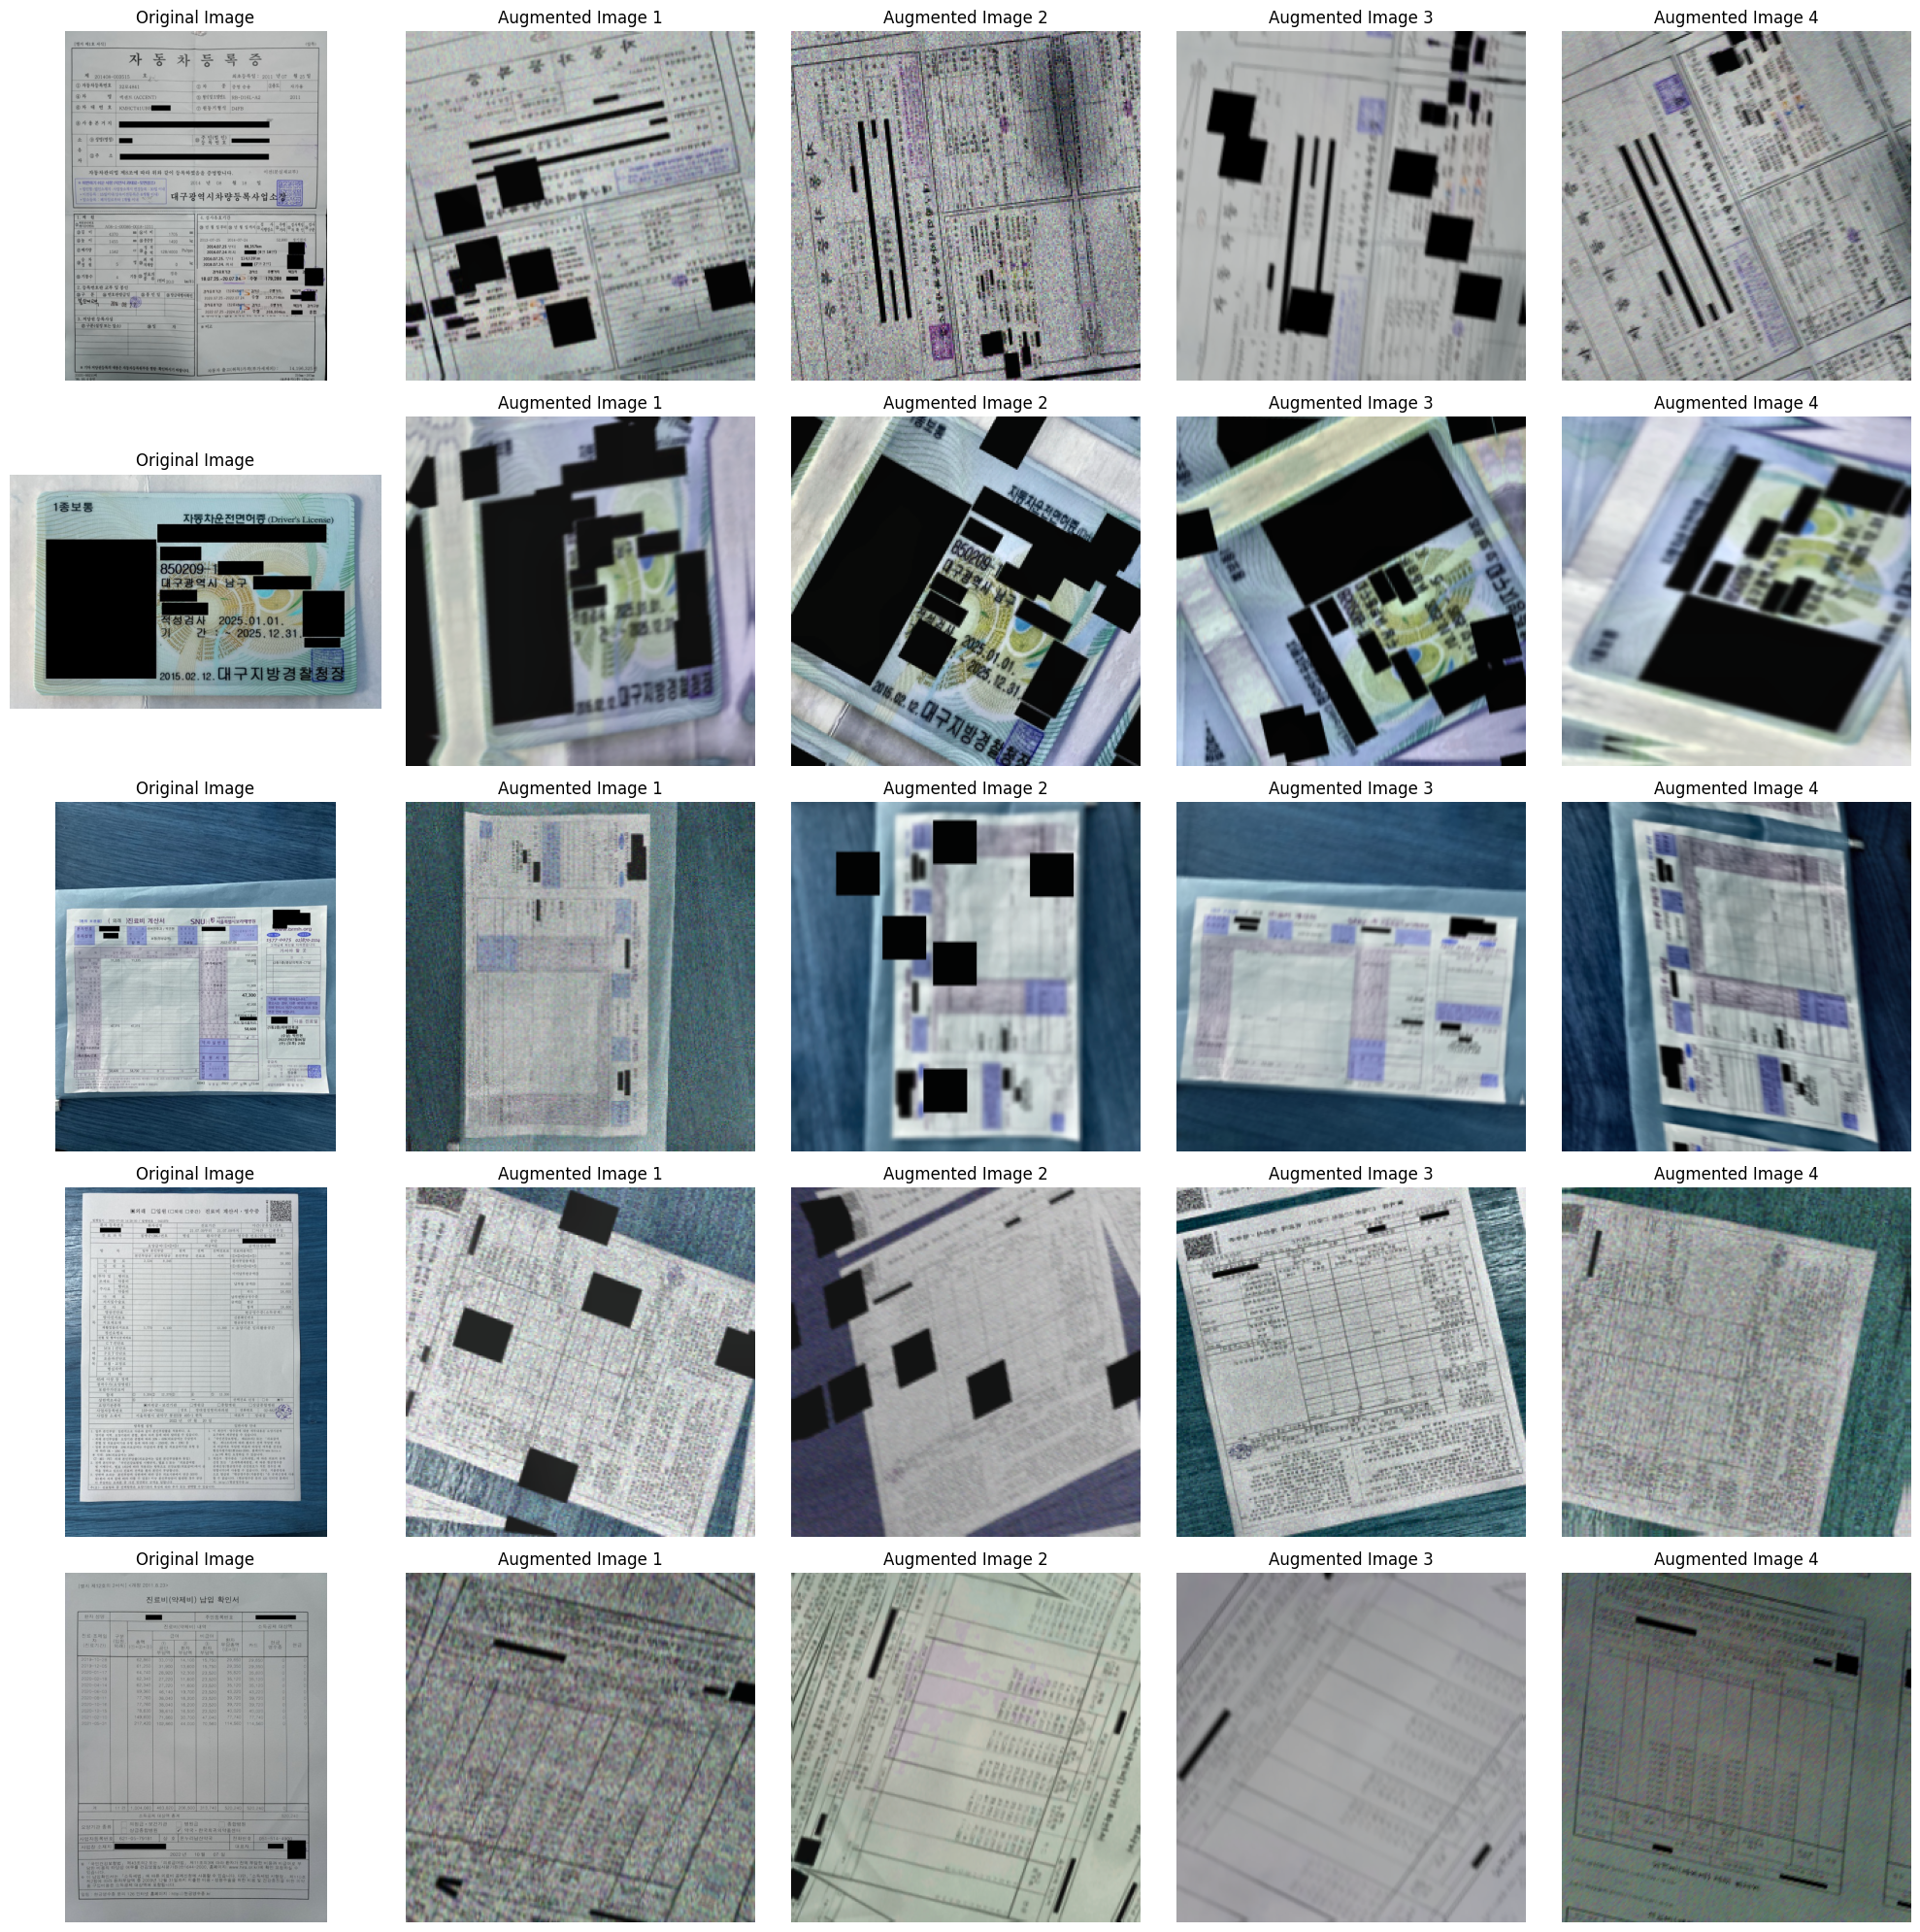

In [15]:

# 시각화 함수
def visualize_augmented_images(dataset, num_images=5, augmentations_per_image=4, data_gap=1570):
    fig, axes = plt.subplots(num_images, augmentations_per_image + 1, figsize=(20, num_images * 4))
    
    for i in range(num_images):
        # 원본 이미지 인덱스
        original_img_index = random.randint(0,ori_traindata_num)
        
        # 원본 이미지 로드
        original_img_path = os.path.join(dataset.path, dataset.df[original_img_index][0])
        original_img = np.array(Image.open(original_img_path))
        
        # 원본 이미지 표시
        axes[i, 0].imshow(original_img)
        axes[i, 0].set_title("Original Image")
        axes[i, 0].axis("off")
        
        # 증강된 이미지 최대 4개 표시
        for j in range(1, augmentations_per_image + 1):
            # 증강된 이미지를 올바르게 가져오기 위해, 증강 비율을 사용하여 인덱스를 계산
            augmented_idx = original_img_index + data_gap * (j - 1)
            augmented_img, _ = dataset[augmented_idx]
            augmented_img = augmented_img.permute(1, 2, 0).numpy()  # CHW -> HWC
            
            # Normalize 된 이미지를 다시 원래 범위로 변환
            mean = np.array([0.485, 0.456, 0.406])
            std = np.array([0.229, 0.224, 0.225])
            augmented_img = std * augmented_img + mean
            augmented_img = np.clip(augmented_img, 0, 1)
            
            axes[i, j].imshow(augmented_img)
            axes[i, j].set_title(f"Augmented Image {j}")
            axes[i, j].axis("off")
    
    plt.tight_layout()
    plt.show()

# 트레이닝 데이터 시각화
visualize_augmented_images(trn_dataset)

In [16]:

trn_loader = DataLoader(
    trn_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=True,
    drop_last=False
)

tst_loader = DataLoader(
    tst_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=True
)


In [17]:

# 모델을 불러옵니다.
model = timm.create_model(
    model_name,
    pretrained=True,
    num_classes=17,
    drop_rate=0.2  # Dropout 설정
).to(device)

# 손실 함수를 정의합니다.
loss_fn = nn.CrossEntropyLoss()

# 옵티마이저를 정의합니다.
optimizer = AdamW(model.parameters(), lr=LR)

# Learning Rate Scheduler를 정의합니다.
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)

# Early Stopping을 위한 변수 초기화
best_loss = float('inf')
early_stopping_counter = 0


In [18]:
# 각 클래스별 모델 생성 및 학습 함수
def train_model_for_class(class_num):
    model = timm.create_model(
        model_name,
        pretrained=True,
        num_classes=2,  # 이진 분류로 변경
        drop_rate=0.2
    ).to(device)

    loss_fn = nn.CrossEntropyLoss()
    optimizer = AdamW(model.parameters(), lr=LR)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)

    best_loss = float('inf')
    early_stopping_counter = 0

    for epoch in range(EPOCHS):
        model.train()
        train_loss = 0
        preds_list = []
        targets_list = []

        for image, targets in tqdm(trn_loader):
            image = image.to(device)
            targets = (targets == class_num).long().to(device)  # 이진 분류로 변환

            optimizer.zero_grad(set_to_none=True)

            preds = model(image)
            loss = loss_fn(preds, targets)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            preds_list.extend(preds.argmax(dim=1).detach().cpu().numpy())
            targets_list.extend(targets.detach().cpu().numpy())

        train_loss /= len(trn_loader)
        train_acc = accuracy_score(targets_list, preds_list)
        train_f1 = f1_score(targets_list, preds_list, average='binary')

        print(f"Class {class_num} - Epoch {epoch+1}/{EPOCHS}, Loss: {train_loss:.4f}, Acc: {train_acc:.4f}, F1: {train_f1:.4f}")

        scheduler.step(train_loss)

        if train_loss < best_loss:
            best_loss = train_loss
            early_stopping_counter = 0
            torch.save(model.state_dict(), f"{model_name}_class{class_num}_best_model.pth")
        else:
            early_stopping_counter += 1
            if early_stopping_counter >= early_stopping_patience:
                print(f"Early stopping triggered for class {class_num} after {epoch+1} epochs.")
                break

    return model



In [19]:
# 모든 클래스에 대해 모델 학습
models = []
for class_num in range(17):  # 0부터 16까지의 클래스
    print(f"Training model for class {class_num}")
    model = train_model_for_class(class_num)
    models.append(model)




Training model for class 0


  1%|          | 36/3925 [00:10<16:00,  4.05it/s] 

In [ ]:
# 앙상블 예측 함수
def ensemble_predict(models, loader):
    predictions = []
    for image, _ in tqdm(loader):
        image = image.to(device)
        class_predictions = []
        for model in models:
            model.eval()
            with torch.no_grad():
                preds = model(image)
                class_predictions.append(preds[:, 1].cpu().numpy())  # 클래스에 속할 확률
        class_predictions = np.array(class_predictions).T
        predictions.extend(np.argmax(class_predictions, axis=1))
    return predictions


In [ ]:
# 테스트 데이터에 대한 앙상블 예측 수행
ensemble_preds = ensemble_predict(models, tst_loader)



In [ ]:
# 예측 결과를 데이터프레임으로 저장
pred_df = pd.DataFrame(tst_dataset.df, columns=['ID', 'target'])
pred_df['target'] = ensemble_preds



In [ ]:
# 제출 형식 파일을 읽어와 ID 열이 일치하는지 확인
sample_submission_df = pd.read_csv(f"{data_path}sample_submission.csv")
assert (sample_submission_df['ID'] == pred_df['ID']).all()

# 예측 결과를 CSV 파일로 저장
pred_df.to_csv(f"{model_name}_ensemble_pred.csv", index=False)
print(pred_df.head())